In [342]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf

#df = pd.read_csv("DF.csv")
df2 = pd.read_csv("term_project/DF2_cleaned.csv")

In [40]:
def patsyParse(dVar, iVars, iVarsTypes):
    
    funcformStr = dVar + " ~ "
    
    for index in range(len(iVars)): 
        
        varType = iVarsTypes[index]
        
        if varType == "c":
            
            funcformStr += iVars[index] + " + "
        
        elif varType == "d":
            
            funcformStr += "C(" + iVars[index] + ") + "
            
        else:
        
            _, refName = re.split(r"_", varType, maxsplit=1)
            funcformStr += "C(" + iVars[index] + ", Treatment(" + refName + ") + "
            
    return funcformStr[:len(funcformStr)-3]

def lag(df, colKey, lag):
    
    newColKey = colKey + str(lag)
    df[newColKey] = df[colKey].shift(lag)
    
def removeLastInGroup(df, colKey):
    
    df["remove"] = False
    prev = df[colKey][0]
    
    for ticker in range(len(df[colKey])):
        
        curr = df[colKey][ticker]
        
        if curr != prev:
            
            df["remove"][ticker-1] = True
            
        prev = curr
    
            

In [300]:
counts = df['tic'].value_counts()

validTics = counts[counts >= 16].index

validTics = validTics.tolist()

df_hat = df[df['tic'].isin(validTics)]

df_hat = df_hat[df_hat['difference'] < 1]
df_hat = df_hat[df_hat['difference'] > -1]

df_hat = df_hat.drop(['summary','q_a', 'text', 'id', 'gvkey', 'title', 'name'], axis = 1)

df_hat = df_hat.reset_index(drop=True)

checkNans = ["q_a_score", "summary_score", "industry", "sector"]

for curr in checkNans:

    df_hat = df_hat[df_hat[curr].isna() == False]

    df_hat = df_hat.reset_index(drop=True)

lag(df_hat, "difference", -1)


In [301]:
removeLastInGroup(df_hat, "tic")

df_hat = df_hat[df_hat["remove"] == False]
df_hat = df_hat.iloc[:-1 , :]

C:\Users\Tanner\AppData\Local\Temp\ipykernel_7288\613057405.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["remove"][ticker-1] = True


In [302]:
features = ["summary_score", "q_a_score", "sector"]
featuresType = ["c","c","d"]

funcForm = patsyParse("difference-1", features, featuresType)

initial_mixed_model = smf.mixedlm(funcForm, df_hat, groups=df_hat["tic"])#, re_formula="1 + summary_score + q_a_score")

initial_mm_fit = initial_mixed_model.fit()


C:\Users\Tanner\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


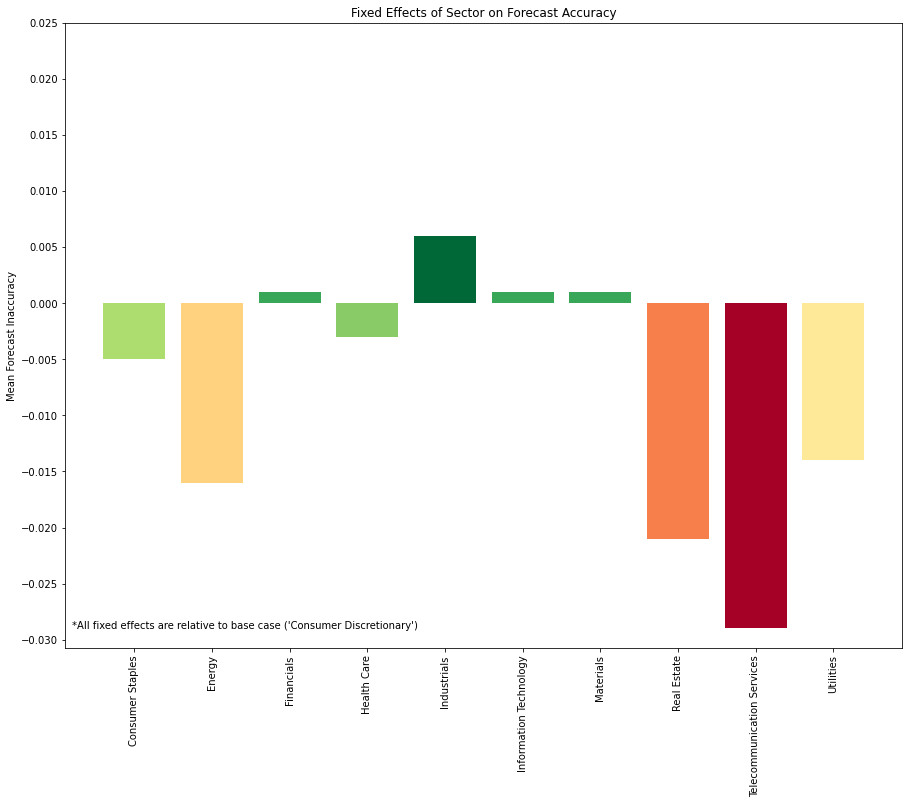

In [304]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

sectors = initial_mm_fit.summary().tables[1]['Coef.'][1:11]

sectors_dict = {}

for i in range(len(sectors)):
    
    sectors[i] = float(sectors[i])

for sector in range(len(sectors.index)):
    
    sectorName = sectors.index[sector][sectors.index[sector].find(".")+1:-1]
    sectors_dict[sectorName] = sectors[sector]
    
x = list(sectors_dict.keys())
y = list(sectors_dict.values())

my_cmap = plt.get_cmap("RdYlGn")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


plt.figure(figsize=(15,11.5))
plt.bar(x, y, color=my_cmap(rescale(y)))
plt.text(-.8,-0.029,"*All fixed effects are relative to base case ('Consumer Discretionary')")
plt.xticks(rotation=90)
plt.yticks(np.arange(-0.03, 0.03, 0.005))
plt.ylabel("Mean Forecast Inaccuracy")
plt.title("Fixed Effects of Sector on Forecast Accuracy")

plt.savefig("sectors",dpi=300, bbox_inches = "tight")

In [305]:
r_fx = []
r_fx_names = []

for each in initial_mm_fit.random_effects.values():
    
    r_fx.append(each)

for each in  initial_mm_fit.random_effects.keys():
    
    r_fx_names.append(each)

r_fx = pd.DataFrame(r_fx)
r_fx['names'] = r_fx_names

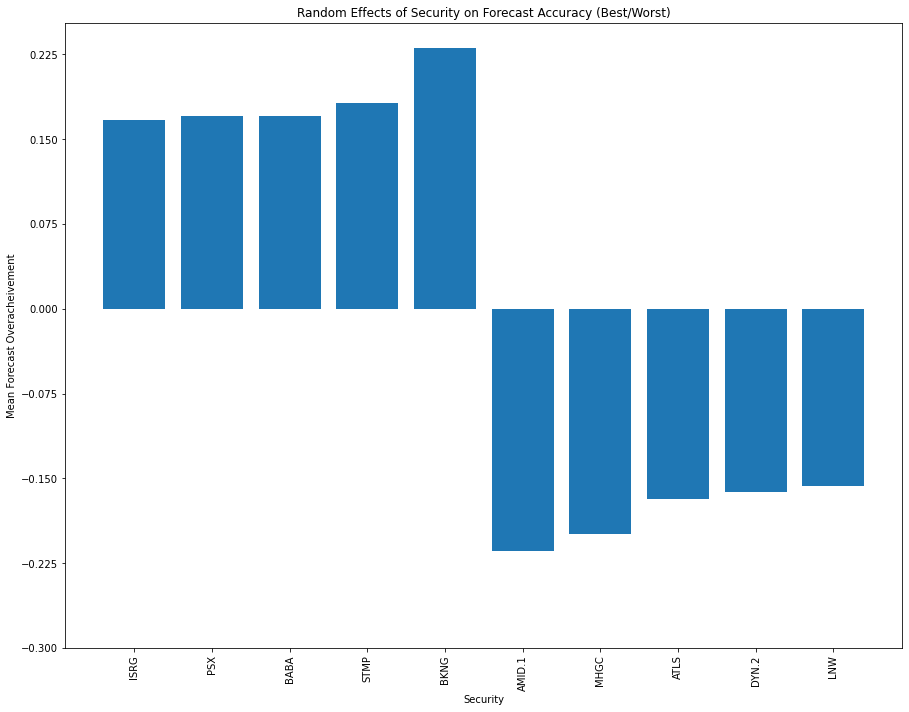

In [330]:
worst5 = r_fx.sort_values(by=['Group'])[:5]
best5 = r_fx.sort_values(by=['Group'])[len(r_fx.sort_values(by=['Group']))-5:]

concatLists = [best5, worst5]

summDf = pd.concat(concatLists)

plt.figure(figsize=(15,11.5))
plt.bar(summDf['names'], summDf['Group'])
plt.xticks(rotation=90)
plt.yticks(np.arange(-0.3, 0.3, 0.075))
plt.ylabel("Mean Forecast Overacheivement")
plt.xlabel("Security")
plt.title("Random Effects of Security on Forecast Accuracy (Best/Worst)", )

plt.savefig("sectors",dpi=300, bbox_inches = "tight")

In [331]:
initial_mm_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
==================================================================================
Model:                      MixedLM         Dependent Variable:         difference
No. Observations:           105800          Method:                     REML      
No. Groups:                 2821            Scale:                      0.0184    
Min. group size:            1               Log-Likelihood:             59167.3102
Max. group size:            76              Converged:                  Yes       
Mean group size:            37.5                                                  
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                               -0.005    0.002 -2.125 0.034 -0.010 -0.000
C(sector)[T.Consumer Staples]           -0.005    0.005 -0.980 0.327 -0.014  0.005
C(sector)[T.Energy]                     -0.016    0.003 -4.677 0.000 -0.023 -0.009
C(sector)[T.Financials]                  0.001    0.011  0.096 0.924 -0.020  0.022
C(sector)[T.Health Care]                -0.003    0.003 -1.018 0.309 -0.009  0.003
C(sector)[T.Industrials]                 0.006    0.003  2.051 0.040  0.000  0.012
C(sector)[T.Information Technology]      0.001    0.003  0.440 0.660 -0.004  0.007
C(sector)[T.Materials]                   0.001    0.004  0.309 0.757 -0.006  0.009
C(sector)[T.Real Estate]                -0.021    0.012 -1.722 0.085 -0.045  0.003
C(sector)[T.Telecommunication Services] -0.029    0.007 -4.025 0.000 -0.043 -0.015
C(sector)[T.Utilities]                  -0.014    0.005 -2.695 0.007 -0.025 -0.004
summary_score                            0.001    0.000 12.542 0.000  0.001  0.002
q_a_score                                0.004    0.000 16.575 0.000  0.003  0.004
Group Var                                0.002    0.000                           
==================================================================================

"""

**Naive Model**

$d_{i_{t+1}}=\theta_{1,j}+\theta_{2,0}vSentimentSummary_{i_t}+\theta_{2,0}vSentimentQA_{i_t}+\begin{bmatrix}\theta_{3,0}\\+\\...\\+\\\theta_{13,0}\end{bmatrix}\begin{bmatrix}segment_{1}+...+segment_{11}\end{bmatrix}+\epsilon_{i_t}$

where $\epsilon_{i}$ = the i.i.d. error for the $i$th observation in the first-level equation, $j$ = some class group (security), $d_{t+1}$ is the difference between actual and forecasted earnings in the next period (our dependent variable), $\theta_{1,j}$ is the random slope term, and all other $\theta$ terms are fixed effects parameter values.

For each group $j$,

$\theta_{1,j} = \alpha + \beta_{1j} + u_{1j}$

where $\alpha$ is the fixed intercept term, $\beta_{1j}$ is the random slope term, and $u_{1j}$ is the i.i.d. error of the $j$th group in the second-level equation

**Naive Model Results**

$\theta_{2,0} = 0.001$, parameter $z$-score $= 12.54$

$\theta_{3,0} = 0.004$, parameter $z$-score $= 16.58$

$\alpha = -0.005$, parameter $z$-score $= -2.13$

$vSentimentSummary$ mean $= 6.56$

$vSentimentQA$ mean $= 5.39$

The results of our naive model show that positive sentiment is positively correlated with "over-performing" quarterly earnings. That is, the higher percentage of positive language used in an earnings call, the more likely it will be that the forecast underestimates earnings for the next quarter. The magnitude of this relationship is higher for the Q&A portion of the call, where, for every 1 positive word per negative word, the company will out-peform their estimate by  0.4%.

**Random Effects Summary**

The $\theta_{1,j}$ terms are too extensive to list here, but generally ranged from $-0.16$ to $0.17$. This means that, for a given security, the expected forecast accuracy can range from often overestimating to often underestimating quarterly earnings. This two-level structure allows us to assume the forecasting regimes of various securities have independent variance. The embedded $u$ error term (variance across time) has a different generating process than the high-level $\epsilon$ term (variance across securities).

In [343]:
lag(df2, "difference", -1)

In [344]:
removeLastInGroup(df2, "tic")

df2 = df2[df2["remove"] == False]
df2 = df2.iloc[:-1 , :]

C:\Users\Tanner\AppData\Local\Temp\ipykernel_7288\613057405.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["remove"][ticker-1] = True


In [348]:
df2 = df2[df2['difference'] < 1]
df2 = df2[df2['difference'] > -1]

In [385]:
checkNans = df2.columns

for curr in checkNans:

    df2 = df2[df2[curr].isna() == False]

    df2 = df2.reset_index(drop=True)
    
    df2 = df2[df2[curr] != np.Inf]

    df2 = df2.reset_index(drop=True)

features = ["summary_conf", "q_a_conf", "summary_sent", "q_a_sent", "sector"]
featuresType = ["c","c","c","c","d"]

funcForm = patsyParse("difference-1", features, featuresType)

initial_mixed_model = smf.mixedlm(funcForm, df2, groups=df2["tic"])#, re_formula="1 + summary_score + q_a_score")

initial_mm_fit = initial_mixed_model.fit()

C:\Users\Tanner\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [387]:
initial_mm_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
==================================================================================
Model:                      MixedLM         Dependent Variable:         difference
No. Observations:           102968          Method:                     REML      
No. Groups:                 2803            Scale:                      0.0185    
Min. group size:            2               Log-Likelihood:             57298.0299
Max. group size:            76              Converged:                  Yes       
Mean group size:            36.7                                                  
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                0.008    0.003  2.739 0.006  0.002  0.014
C(sector)[T.Consumer Staples]           -0.002    0.005 -0.521 0.603 -0.012  0.007
C(sector)[T.Energy]                     -0.018    0.003 -5.208 0.000 -0.025 -0.011
C(sector)[T.Financials]                  0.000    0.011  0.006 0.995 -0.021  0.022
C(sector)[T.Health Care]                -0.008    0.003 -2.688 0.007 -0.014 -0.002
C(sector)[T.Industrials]                 0.003    0.003  0.900 0.368 -0.003  0.009
C(sector)[T.Information Technology]     -0.003    0.003 -1.187 0.235 -0.009  0.002
C(sector)[T.Materials]                   0.001    0.004  0.194 0.846 -0.007  0.009
C(sector)[T.Real Estate]                -0.024    0.012 -1.928 0.054 -0.048  0.000
C(sector)[T.Telecommunication Services] -0.032    0.007 -4.340 0.000 -0.046 -0.017
C(sector)[T.Utilities]                  -0.014    0.005 -2.579 0.010 -0.025 -0.003
summary_conf                             0.004    0.001  7.064 0.000  0.003  0.005
q_a_conf                                -0.006    0.002 -3.728 0.000 -0.009 -0.003
summary_sent                             0.001    0.000 14.720 0.000  0.001  0.002
q_a_sent                                 0.003    0.000 11.659 0.000  0.002  0.003
Group Var                                0.002    0.000                           
==================================================================================

"""

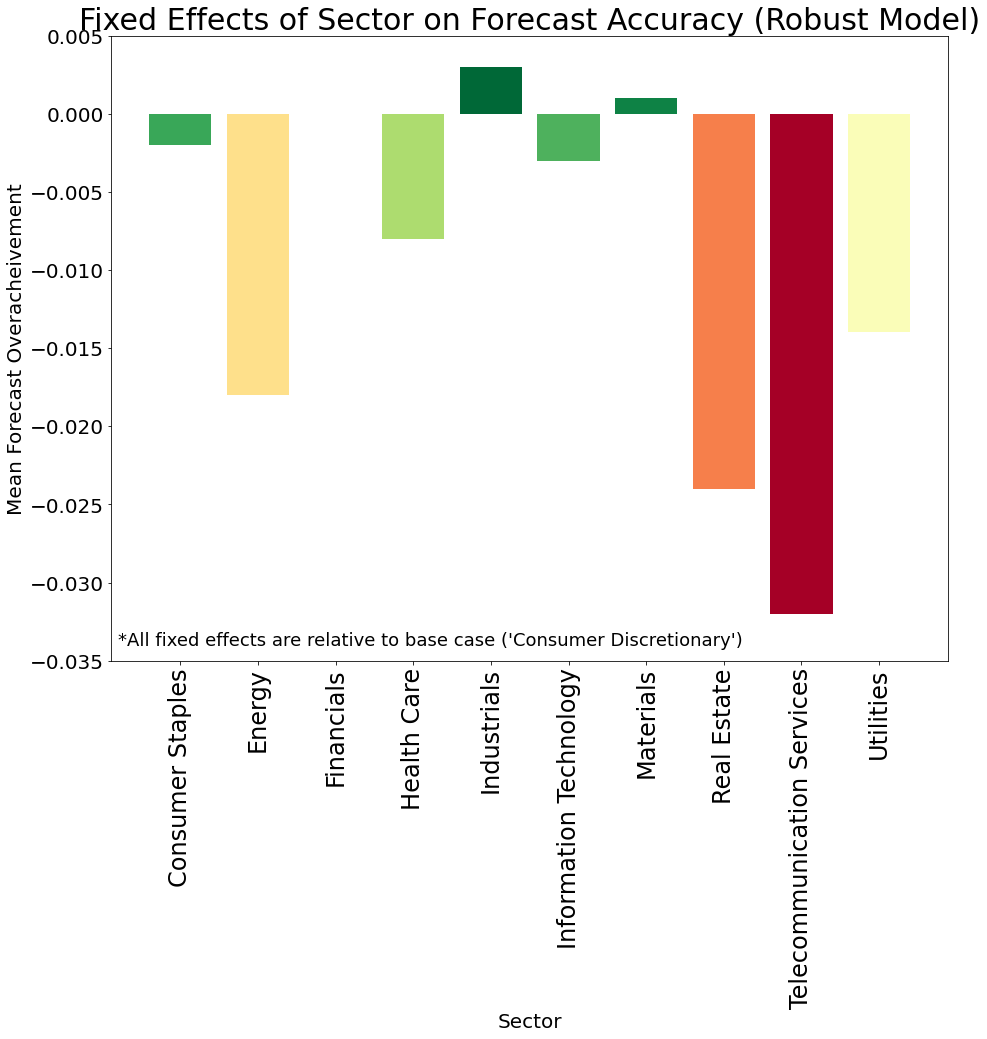

In [469]:
sectors = initial_mm_fit.summary().tables[1]['Coef.'][1:11]

sectors_dict = {}

for i in range(len(sectors)):
    
    sectors[i] = float(sectors[i])

for sector in range(len(sectors.index)):
    
    sectorName = sectors.index[sector][sectors.index[sector].find(".")+1:-1]
    sectors_dict[sectorName] = sectors[sector]
    
x = list(sectors_dict.keys())
y = list(sectors_dict.values())

my_cmap = plt.get_cmap("RdYlGn")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


plt.figure(figsize=(15,11.5))
plt.bar(x, y, color=my_cmap(rescale(y)))
plt.text(-.8,-0.034,"*All fixed effects are relative to base case ('Consumer Discretionary')", fontsize = 18)
plt.xticks(rotation=90, fontsize = 24)
plt.yticks(np.arange(-0.035, 0.01, 0.005), fontsize = 20)
plt.ylabel("Mean Forecast Overacheivement", fontsize = 20)
plt.xlabel("Sector", fontsize = 20)
plt.title("Fixed Effects of Sector on Forecast Accuracy (Robust Model)", fontsize = 30)

plt.savefig("term_project/sectors",dpi=300, bbox_inches = "tight")

In [402]:
r_fx = []
r_fx_names = []

for each in initial_mm_fit.random_effects.values():
    
    r_fx.append(each)

for each in  initial_mm_fit.random_effects.keys():
    
    r_fx_names.append(each)

r_fx = pd.DataFrame(r_fx)
r_fx['names'] = r_fx_names

In [412]:
def getFreqs(df, arr):
    
    freqs = []
    
    for each in arr:
        
        freqs.append(len(df[df['tic'] == each]))
    
    return freqs

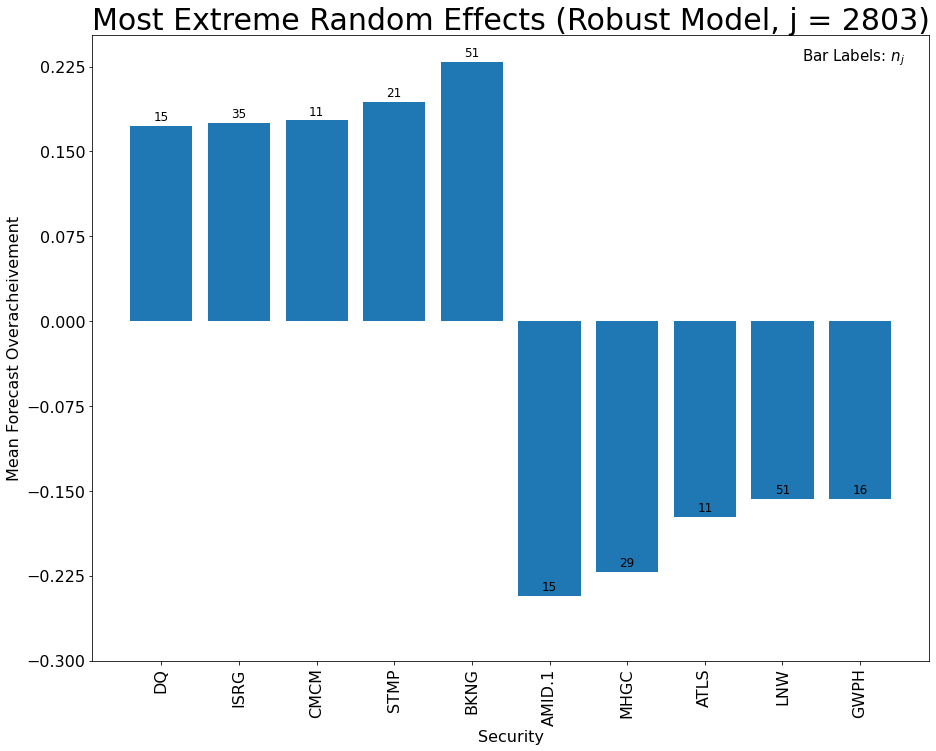

In [464]:
worst5 = r_fx.sort_values(by=['Group'])[:5]
best5 = r_fx.sort_values(by=['Group'])[len(r_fx.sort_values(by=['Group']))-5:]

concatLists = [best5, worst5]

summDf = pd.concat(concatLists)

plt.figure(figsize=(15,11.5))
plt.bar(summDf['names'], summDf['Group'])
plt.xticks(rotation=90, fontsize = 16)
plt.yticks(np.arange(-0.3, 0.3, 0.075), fontsize = 16)
plt.ylabel("Mean Forecast Overacheivement", fontsize = 16)
plt.xlabel("Security", fontsize = 16)
plt.title("Most Extreme Random Effects (Robust Model, j = 2803)", fontsize = 30)
plt.text(8.25,0.23,"Bar Labels: $n_{j}$", fontsize = 15)

extremeFreqs = getFreqs(df2, summDf['names'])

for i in range(10):
        plt.text(i, summDf['Group'].iloc[i]+0.005, extremeFreqs[i], ha = 'center', fontsize = 12)


plt.savefig("term_project/randomFx",dpi=300, bbox_inches = "tight")

**Robust Model**

The robust model aims to incorporate more "tactical" dictionaries when analyzing earnings call language. This model replaces the NLKT.Vader scores with a more parameterized method (albeit simpler computationally). This model includes both a $sentiment$ and $confidence$ characeterization of earnings calls, whereas the Vader score only took into consideration $sentiment$. For further details, see 'Methods'.

This model is identical in hierarchical structure, with a few more parameters:

$d_{i_{t+1}}=\theta_{1,j}+\theta_{2,0}rSentimentSummary_{i_t}+\theta_{3,0}rSentimentQA_{i_t}+\theta_{4,0}rConfidenceSummary_{i_t}+\theta_{5,0}rConfidenceQA_{i_t}+\begin{bmatrix}\theta_{6,0}\\+\\...\\+\\\theta_{16,0}\end{bmatrix}\begin{bmatrix}segment_{1}+...+segment_{11}\end{bmatrix}+\epsilon_{i_t}$

The "r" prefix denotes our new robust scoring method. $\theta_{3,0}$ and $\theta_{4,0}$ are new terms representing the confidence score of an earnings call.

The second-level functional form remains the same as the naive model. 



**Robust Model Results**

$\theta_{2,0} = 0.001$, parameter $z$-score $= 14.72$

$\theta_{3,0} = 0.003$, parameter $z$-score $= 11.66$

$\theta_{4,0} = 0.004$, parameter $z$-score $= 7.06$

$\theta_{5,0} = -0.006$, parameter $z$-score $= -3.73$

$\alpha = 0.008$, parameter $z$-score $= 2.74$

$rSentimentSummary$ mean $= 5.87$

$rSentimentQA$ mean $= 3.89$

$rConfidenceSummary$ mean $= 1.62$

$rConfidenceQA$ mean $= 1.01$

At first glance, our robust model looks promising. Our new theta values look significant, and our coefficients have nice interpretations. These coefficients are similar in scale to those of the naive model, which seems coincedental; but as we take a few samples around the mean, we see that the result scales are similar as well. 

Our $sentiment$ terms follow very closely with the robust model, as we again see that a more positive sentiment leads to overperformance. The Q&A portion of the call again has a larger effect. For every 1 positive word per negative word in the Q&A portion, the company will out-perform the estimate by 0.3%. This is very similar to the naive model, although observation interpretations vary slightly.

The new insights gained from this model come from our new $confidence$ parameters. Language signifying confidence, surety, etc. lend to overperformance when found in the 'Summary' section, but has the exact opposite effect in the 'Q&A' section. The negative coefficient for $\theta_{5,0}$ indicates that high confidence during the Q&A portion of a call will lead to underperformance. 

**What does this really mean?**

Because the Q&A section is much more defensive in nature, words of assurance may actually signify insecurity; and therefore leading the general public to believe that performance will be higher in the future than it actually will be. The summary is much more introspective, and words of confidence could be "undervalued" by forecasters. 

**Random Effects Summary**

The $\theta_{1,j}$ terms in this model had slightly higher variance, generally ranging from $-0.22$ to $0.22$. See the "Most Extreme Random Effects" visualization for more details>

In [461]:
np.mean(df2['q_a_conf'])

1.0138290536865977